## 1. 📚 Importation des Bibliothèques

Importation de tous les modules nécessaires pour la génération de données, l'analyse statistique et les visualisations.

In [1]:
# Importation des bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# Configuration pour l'affichage dans le notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Toutes les bibliothèques ont été importées avec succès!")

✅ Toutes les bibliothèques ont été importées avec succès!


## 2. 🏗️ Classe RadioPropagationDataGenerator

Définition de la classe principale qui génère des données réalistes de propagation radio indoor en utilisant des modèles physiques.

In [2]:
class RadioPropagationDataGenerator:
    """Générateur de données de propagation radio réaliste"""
    
    def __init__(self, random_seed=42):
        """
        Initialise le générateur
        
        Args:
            random_seed: Graine pour la reproductibilité
        """
        np.random.seed(random_seed)
        
        # Paramètres physiques réalistes
        self.wall_loss_db = 3.5  # Perte par mur (dB)
        self.floor_loss_db = 15.0  # Perte par étage (dB)
        self.reference_freq = 2400  # Fréquence de référence (MHz)
        self.reference_distance = 1.0  # Distance de référence (m)
        
        # Paramètres d'environnement
        self.noise_std = 2.5  # Écart-type du bruit (dB)
        self.shadow_fading_std = 4.0  # Écart-type du shadowing (dB)
        
        print(f"🔧 Générateur initialisé avec:")
        print(f"   - Perte par mur: {self.wall_loss_db} dB")
        print(f"   - Perte par étage: {self.floor_loss_db} dB")
        print(f"   - Fréquence de référence: {self.reference_freq} MHz")
        
    def free_space_loss(self, distance, frequency):
        """Calcule la perte en espace libre (modèle de Friis)"""
        return 20 * np.log10(distance) + 20 * np.log10(frequency) + 32.45
    
    def one_slope_model(self, distance, frequency, n=2.0):
        """Modèle à une pente pour environnement indoor"""
        pl_ref = self.free_space_loss(self.reference_distance, frequency)
        return pl_ref + 10 * n * np.log10(distance / self.reference_distance)
    
    def wall_floor_loss(self, num_walls, num_floors):
        """Calcule les pertes dues aux obstacles"""
        wall_loss = num_walls * self.wall_loss_db
        floor_loss = num_floors * self.floor_loss_db
        return wall_loss + floor_loss
    
    def frequency_dependent_loss(self, frequency):
        """Perte dépendante de la fréquence"""
        return 20 * np.log10(frequency / self.reference_freq)
    
    def environmental_effects(self, distance, num_walls, frequency):
        """Effets environnementaux complexes"""
        # Effet de densité (plus de murs = plus d'absorption)
        density_effect = 0.5 * num_walls * np.log10(distance)
        
        # Effet multi-trajet (dépend de la fréquence et distance)
        multipath_effect = 2.0 * np.sin(2 * np.pi * frequency * distance / 300) ** 2
        
        # Effet de résonance dans les couloirs
        resonance_effect = 0.3 * np.sin(np.pi * frequency / 100)
        
        return density_effect + multipath_effect + resonance_effect
    
    def calculate_pathloss(self, distance, num_walls, num_floors, frequency):
        """Calcule la perte de propagation totale"""
        # Modèle de base (one-slope)
        base_loss = self.one_slope_model(distance, frequency, n=2.8)
        
        # Pertes dues aux obstacles
        obstacle_loss = self.wall_floor_loss(num_walls, num_floors)
        
        # Effet de la fréquence
        freq_loss = self.frequency_dependent_loss(frequency)
        
        # Effets environnementaux
        env_effects = self.environmental_effects(distance, num_walls, frequency)
        
        # Shadowing (log-normal)
        shadowing = np.random.normal(0, self.shadow_fading_std)
        
        # Bruit de mesure
        noise = np.random.normal(0, self.noise_std)
        
        total_loss = (base_loss + obstacle_loss + freq_loss + 
                     env_effects + shadowing + noise)
        
        return max(total_loss, 30.0)  # Minimum réaliste de 30 dB

print("✅ Classe RadioPropagationDataGenerator définie!")

✅ Classe RadioPropagationDataGenerator définie!


In [3]:
# Ajout des méthodes de génération à la classe
def generate_realistic_scenarios(self, n_samples):
    """Génère des scénarios réalistes de propagation"""
    distances = []
    num_walls = []
    num_floors = []
    frequencies = []
    
    for _ in range(n_samples):
        # Distance: distribution log-normale (plus réaliste)
        distance = np.random.lognormal(mean=2.5, sigma=0.8)
        distance = np.clip(distance, 0.5, 100.0)
        distances.append(distance)
        
        # Nombre de murs: dépend de la distance
        if distance < 5:
            wall_prob = np.random.poisson(lam=0.5)
        elif distance < 15:
            wall_prob = np.random.poisson(lam=1.5)
        elif distance < 30:
            wall_prob = np.random.poisson(lam=3.0)
        else:
            wall_prob = np.random.poisson(lam=5.0)
        
        num_walls.append(min(wall_prob, 10))  # Maximum 10 murs
        
        # Nombre d'étages: corrélé avec la distance
        if distance < 10:
            floor_diff = np.random.choice([0, 1], p=[0.8, 0.2])
        elif distance < 25:
            floor_diff = np.random.choice([0, 1, 2], p=[0.4, 0.4, 0.2])
        else:
            floor_diff = np.random.choice([0, 1, 2, 3, 4], p=[0.2, 0.3, 0.3, 0.15, 0.05])
        
        num_floors.append(floor_diff)
        
        # Fréquences communes en WiFi et télécoms
        freq_choices = [900, 1800, 2400, 5000, 5800]
        freq_weights = [0.1, 0.15, 0.4, 0.25, 0.1]  # 2.4GHz plus commun
        frequency = np.random.choice(freq_choices, p=freq_weights)
        
        # Ajouter de la variabilité autour des fréquences standard
        frequency += np.random.normal(0, 50)
        frequency = max(frequency, 800)  # Minimum 800 MHz
        frequencies.append(frequency)
    
    return (np.array(distances), np.array(num_walls), 
            np.array(num_floors), np.array(frequencies))

def generate_dataset(self, n_samples=10000, save_path=None):
    """Génère le dataset complet"""
    print(f"📊 Génération de {n_samples} échantillons...")
    
    # Génération des paramètres
    distances, walls, floors, frequencies = self.generate_realistic_scenarios(n_samples)
    
    # Calcul des pertes de propagation
    print("⚡ Calcul des pertes de propagation...")
    pathlosses = []
    
    for i in range(n_samples):
        if i % 1000 == 0:
            print(f"   Progression: {i}/{n_samples} ({100*i/n_samples:.1f}%)")
            
        pl = self.calculate_pathloss(
            distances[i], walls[i], floors[i], frequencies[i]
        )
        pathlosses.append(pl)
    
    # Création du DataFrame
    data = {
        'distance': distances.round(2),
        'numwall': walls.astype(int),
        'etage': floors.astype(int),
        'frequence': frequencies.round(1),
        'pathloss': np.array(pathlosses).round(2)
    }
    
    df = pd.DataFrame(data)
    
    print(f"✅ Dataset généré avec {len(df)} échantillons")
    
    # Sauvegarde
    if save_path:
        df.to_csv(save_path, index=False)
        print(f"💾 Dataset sauvegardé: {save_path}")
    
    return df

# Ajouter les méthodes à la classe
RadioPropagationDataGenerator.generate_realistic_scenarios = generate_realistic_scenarios
RadioPropagationDataGenerator.generate_dataset = generate_dataset

print("✅ Méthodes de génération ajoutées à la classe!")

✅ Méthodes de génération ajoutées à la classe!


## 3. 🚀 Initialisation du Générateur

Création d'une instance du générateur avec configuration des paramètres.

In [4]:
# Création du générateur avec une graine aléatoire pour la reproductibilité
generator = RadioPropagationDataGenerator(random_seed=42)

print("🎯 Générateur prêt pour la génération de données!")

🔧 Générateur initialisé avec:
   - Perte par mur: 3.5 dB
   - Perte par étage: 15.0 dB
   - Fréquence de référence: 2400 MHz
🎯 Générateur prêt pour la génération de données!


## 4. 📊 Génération du Dataset

Génération d'un dataset de propagation radio avec 5000 échantillons (taille réduite pour un notebook interactif).

In [5]:
# Génération du dataset (taille réduite pour notebook interactif)
df = generator.generate_dataset(
    n_samples=10000, 
    save_path='radio_dataset_notebook.csv'
)

# Affichage des premières lignes
print("\n📋 Aperçu du dataset généré:")
print(df.head(10))

print(f"\n📈 Statistiques rapides:")
print(f"   - Nombre d'échantillons: {len(df)}")
print(f"   - Distance moyenne: {df['distance'].mean():.2f} m")
print(f"   - Pathloss moyen: {df['pathloss'].mean():.2f} dB")
print(f"   - Murs moyens: {df['numwall'].mean():.2f}")
print(f"   - Étages moyens: {df['etage'].mean():.2f}")

📊 Génération de 10000 échantillons...
⚡ Calcul des pertes de propagation...
   Progression: 0/10000 (0.0%)
   Progression: 1000/10000 (10.0%)
   Progression: 2000/10000 (20.0%)
   Progression: 3000/10000 (30.0%)
   Progression: 4000/10000 (40.0%)
   Progression: 5000/10000 (50.0%)
   Progression: 6000/10000 (60.0%)
   Progression: 7000/10000 (70.0%)
   Progression: 8000/10000 (80.0%)
   Progression: 9000/10000 (90.0%)
✅ Dataset généré avec 10000 échantillons
💾 Dataset sauvegardé: radio_dataset_notebook.csv

📋 Aperçu du dataset généré:
   distance  numwall  etage  frequence  pathloss
0     18.13        3      0     4993.1    156.33
1     43.09        3      0     1838.4    152.20
2     14.78        1      1     1704.3    141.74
3      5.89        2      0     2329.4    124.47
4     13.43        0      0     5774.2    149.79
5      7.53        2      0      885.4    117.71
6     10.14        1      1     2419.5    141.29
7     14.51        1      0      944.1    123.34
8      5.43       

## 5. 📈 Analyse Statistique Détaillée

Analyse complète du dataset généré avec statistiques descriptives et validation physique.

In [6]:
# Statistiques descriptives complètes
print("="*60)
print("📊 ANALYSE STATISTIQUE COMPLÈTE")
print("="*60)

print("\n1. STATISTIQUES DESCRIPTIVES:")
print(df.describe())

print("\n2. MATRICE DE CORRÉLATION:")
correlation_matrix = df.corr()
print(correlation_matrix.round(3))

print("\n3. DISTRIBUTIONS PAR VARIABLE:")
for col in df.columns:
    print(f"\n{col.upper()}:")
    print(f"  Min: {df[col].min():.2f}")
    print(f"  Max: {df[col].max():.2f}")
    print(f"  Moyenne: {df[col].mean():.2f}")
    print(f"  Médiane: {df[col].median():.2f}")
    print(f"  Écart-type: {df[col].std():.2f}")

print("\n4. VALIDATION PHYSIQUE:")
# Vérification que pathloss augmente avec distance
corr_dist_pl = df['distance'].corr(df['pathloss'])
print(f"  Corrélation distance-pathloss: {corr_dist_pl:.3f} (attendu > 0.7)")

# Vérification que pathloss augmente avec obstacles
corr_wall_pl = df['numwall'].corr(df['pathloss'])
print(f"  Corrélation murs-pathloss: {corr_wall_pl:.3f} (attendu > 0.3)")

corr_floor_pl = df['etage'].corr(df['pathloss'])
print(f"  Corrélation étages-pathloss: {corr_floor_pl:.3f} (attendu > 0.2)")

# Plage de valeurs réalistes
pl_range = df['pathloss'].max() - df['pathloss'].min()
print(f"  Plage pathloss: {pl_range:.1f} dB (attendu 50-120 dB)")

print("\n5. QUALITÉ DU DATASET:")
if corr_dist_pl > 0.7 and corr_wall_pl > 0.3 and 50 <= pl_range <= 120:
    print("  ✅ Dataset physiquement cohérent")
else:
    print("  ⚠️ Certaines corrélations pourraient être améliorées")

📊 ANALYSE STATISTIQUE COMPLÈTE

1. STATISTIQUES DESCRIPTIVES:
           distance      numwall        etage     frequence      pathloss
count  10000.000000  10000.00000  10000.00000  10000.000000  10000.000000
mean      16.706099      2.22890      0.68280   3162.922130    153.267928
std       14.948604      2.01874      0.86779   1597.357515     27.500113
min        0.500000      0.00000      0.00000    800.000000     75.720000
25%        7.060000      1.00000      0.00000   2217.600000    133.052500
50%       12.095000      2.00000      0.00000   2415.700000    149.405000
75%       21.010000      3.00000      1.00000   4985.900000    170.200000
max      100.000000     10.00000      4.00000   5956.900000    265.070000

2. MATRICE DE CORRÉLATION:
           distance  numwall  etage  frequence  pathloss
distance      1.000    0.597  0.456     -0.007     0.721
numwall       0.597    1.000  0.319     -0.001     0.682
etage         0.456    0.319  1.000      0.001     0.749
frequence    -0.

## 6. 📊 Visualisations Principales

Graphiques essentiels pour comprendre la distribution et les relations dans les données.

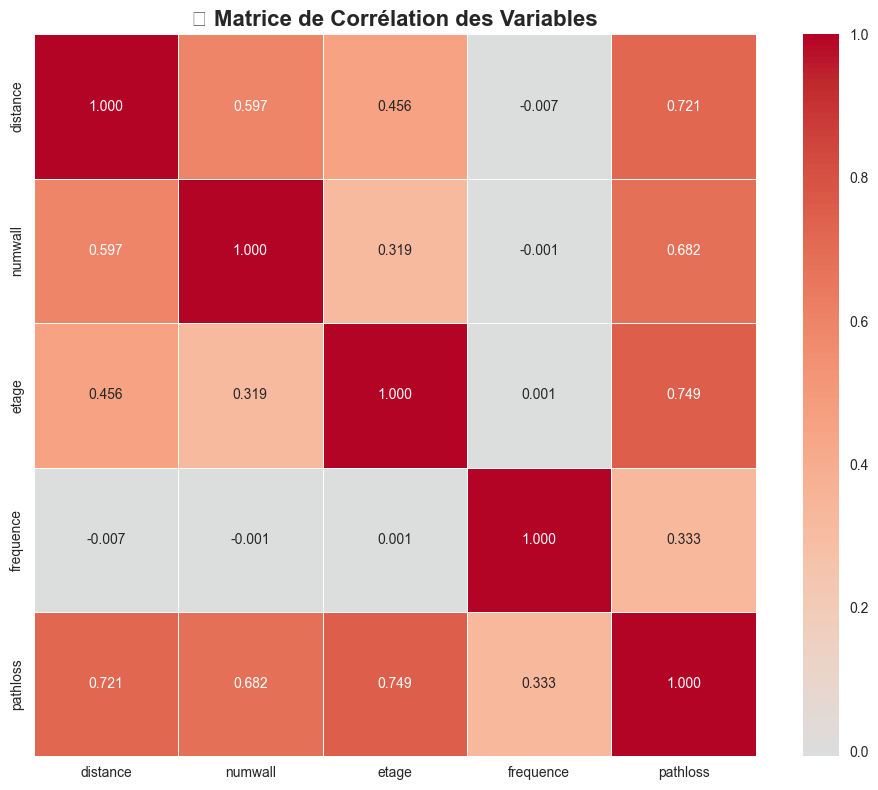

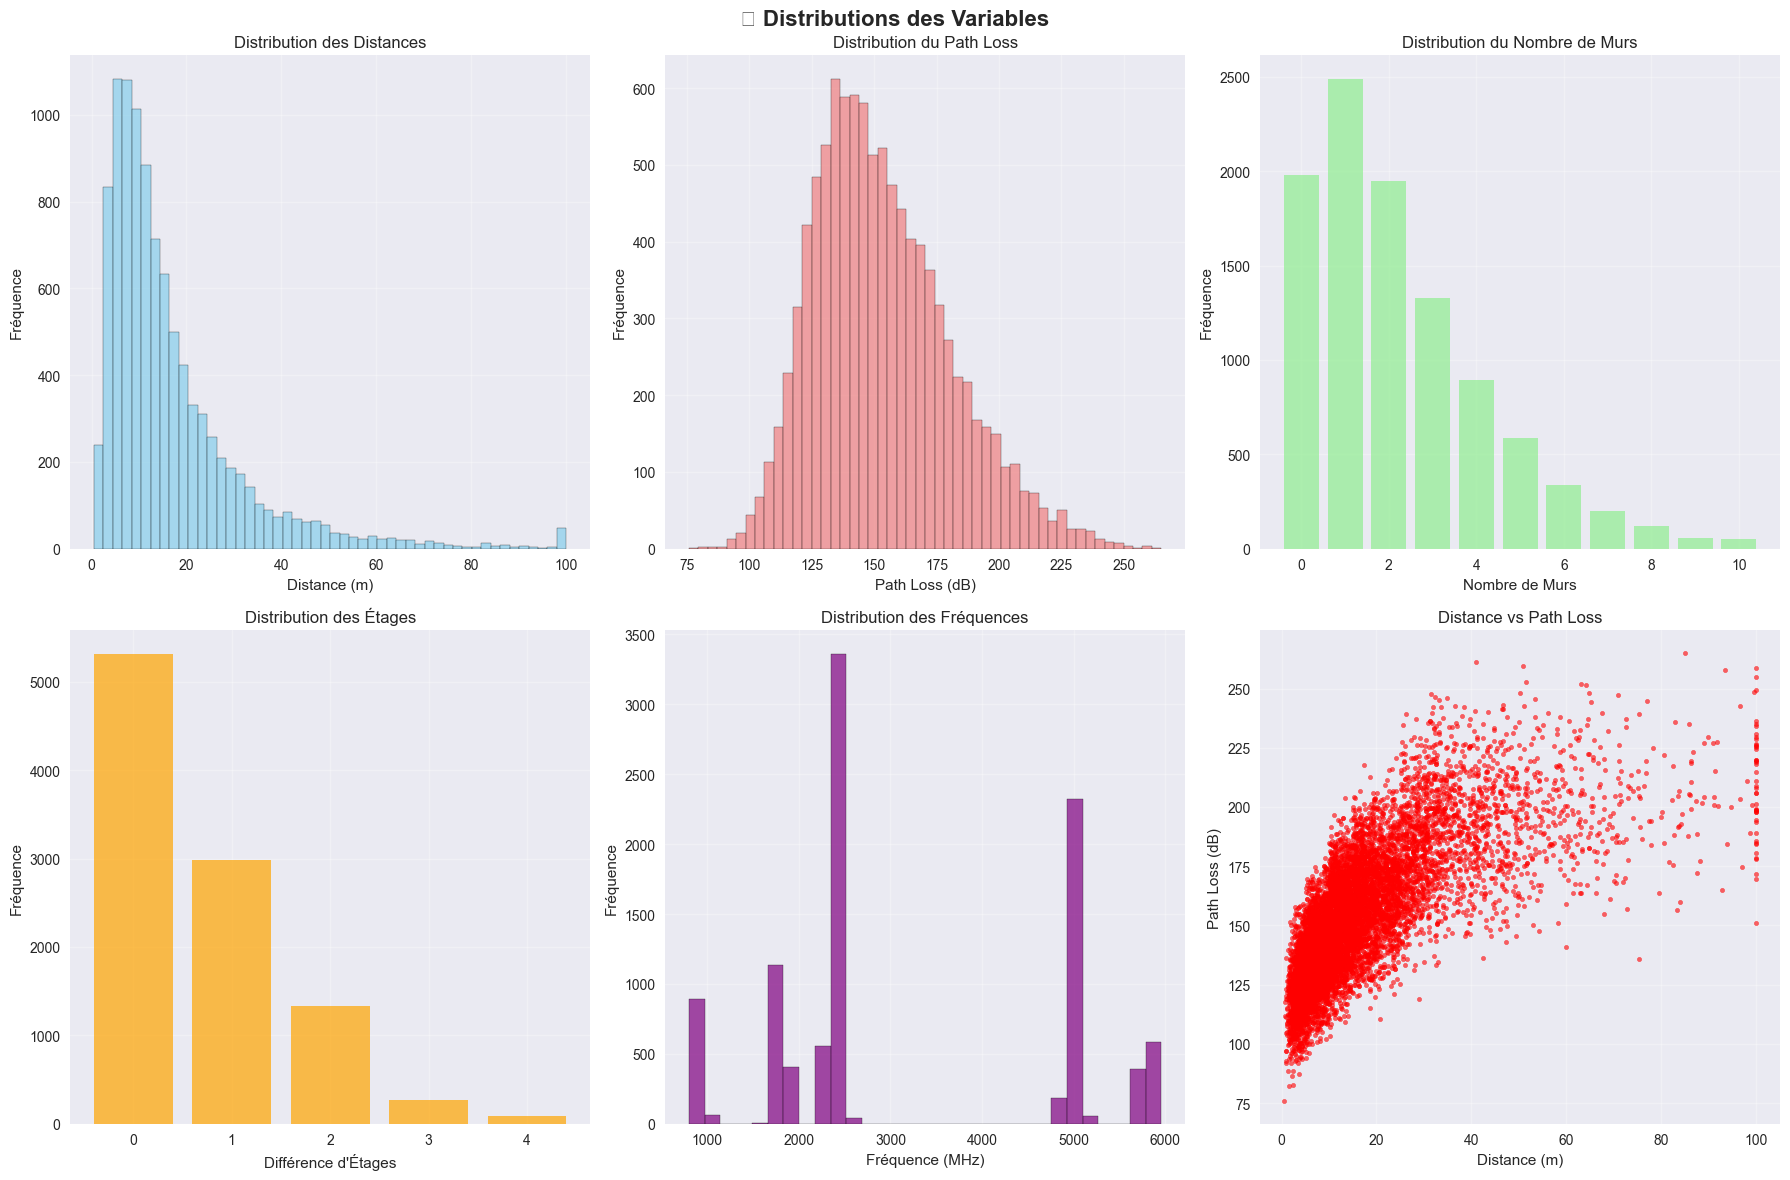

In [7]:
# 1. Matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f', 
            square=True, linewidths=0.5)
plt.title('🔗 Matrice de Corrélation des Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Distributions des variables principales
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('📈 Distributions des Variables', fontsize=16, fontweight='bold')

# Distance
axes[0,0].hist(df['distance'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Distance (m)')
axes[0,0].set_ylabel('Fréquence')
axes[0,0].set_title('Distribution des Distances')
axes[0,0].grid(True, alpha=0.3)

# Path Loss
axes[0,1].hist(df['pathloss'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_xlabel('Path Loss (dB)')
axes[0,1].set_ylabel('Fréquence')
axes[0,1].set_title('Distribution du Path Loss')
axes[0,1].grid(True, alpha=0.3)

# Nombre de murs
wall_counts = df['numwall'].value_counts().sort_index()
axes[0,2].bar(wall_counts.index, wall_counts.values, alpha=0.7, color='lightgreen')
axes[0,2].set_xlabel('Nombre de Murs')
axes[0,2].set_ylabel('Fréquence')
axes[0,2].set_title('Distribution du Nombre de Murs')
axes[0,2].grid(True, alpha=0.3)

# Étages
floor_counts = df['etage'].value_counts().sort_index()
axes[1,0].bar(floor_counts.index, floor_counts.values, alpha=0.7, color='orange')
axes[1,0].set_xlabel('Différence d\'Étages')
axes[1,0].set_ylabel('Fréquence')
axes[1,0].set_title('Distribution des Étages')
axes[1,0].grid(True, alpha=0.3)

# Fréquences
axes[1,1].hist(df['frequence'], bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1,1].set_xlabel('Fréquence (MHz)')
axes[1,1].set_ylabel('Fréquence')
axes[1,1].set_title('Distribution des Fréquences')
axes[1,1].grid(True, alpha=0.3)

# Relation Distance vs Path Loss
axes[1,2].scatter(df['distance'], df['pathloss'], alpha=0.6, s=10, color='red')
axes[1,2].set_xlabel('Distance (m)')
axes[1,2].set_ylabel('Path Loss (dB)')
axes[1,2].set_title('Distance vs Path Loss')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

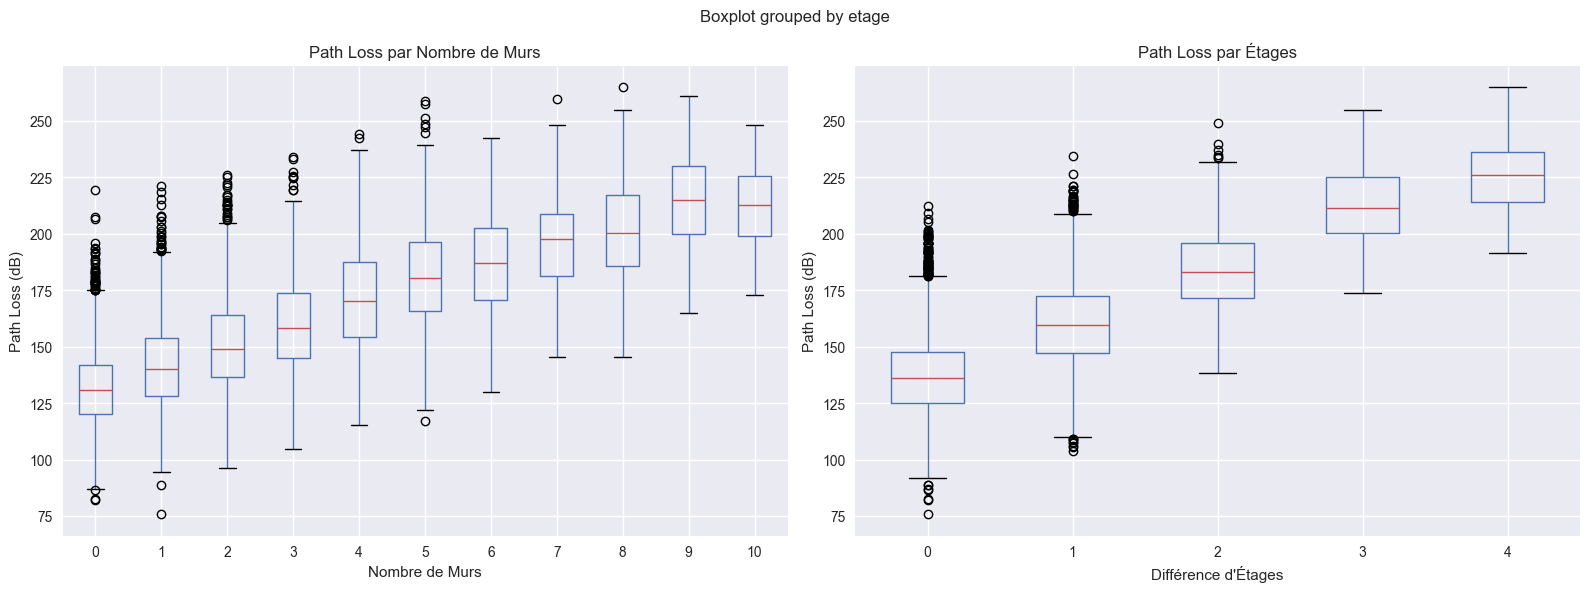

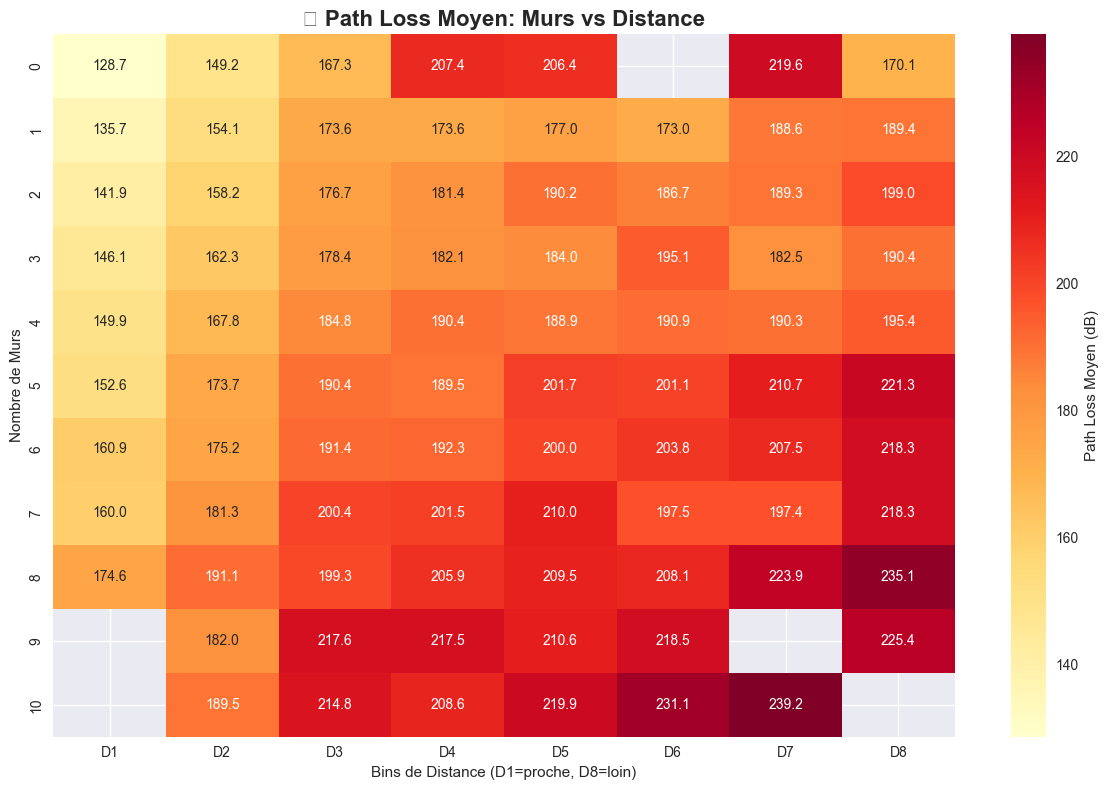

In [8]:
# 3. Boxplots pour analyser l'impact des obstacles
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('📦 Impact des Obstacles sur le Path Loss', fontsize=16, fontweight='bold')

# Path Loss par nombre de murs
df.boxplot(column='pathloss', by='numwall', ax=axes[0])
axes[0].set_title('Path Loss par Nombre de Murs')
axes[0].set_xlabel('Nombre de Murs')
axes[0].set_ylabel('Path Loss (dB)')

# Path Loss par étages
df.boxplot(column='pathloss', by='etage', ax=axes[1])
axes[1].set_title('Path Loss par Étages')
axes[1].set_xlabel('Différence d\'Étages')
axes[1].set_ylabel('Path Loss (dB)')

plt.tight_layout()
plt.show()

# 4. Heatmap Distance vs Murs (Path Loss moyen)
plt.figure(figsize=(12, 8))

# Création des bins pour le heatmap
df_binned = df.copy()
df_binned['dist_bin'] = pd.cut(df['distance'], bins=8, labels=[f'D{i+1}' for i in range(8)])
df_binned['wall_bin'] = df['numwall']

# Calcul du path loss moyen pour chaque combinaison
heatmap_data = df_binned.groupby(['wall_bin', 'dist_bin'])['pathloss'].mean().unstack()

sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.1f', cbar_kws={'label': 'Path Loss Moyen (dB)'})
plt.title('🔥 Path Loss Moyen: Murs vs Distance', fontsize=16, fontweight='bold')
plt.xlabel('Bins de Distance (D1=proche, D8=loin)')
plt.ylabel('Nombre de Murs')
plt.tight_layout()
plt.show()

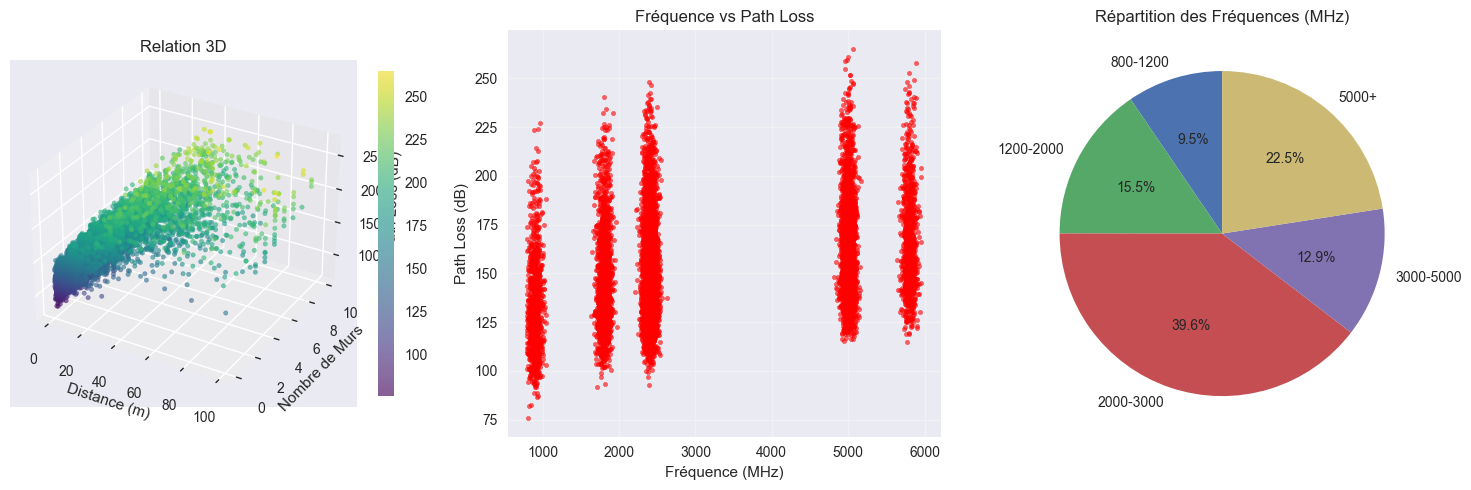

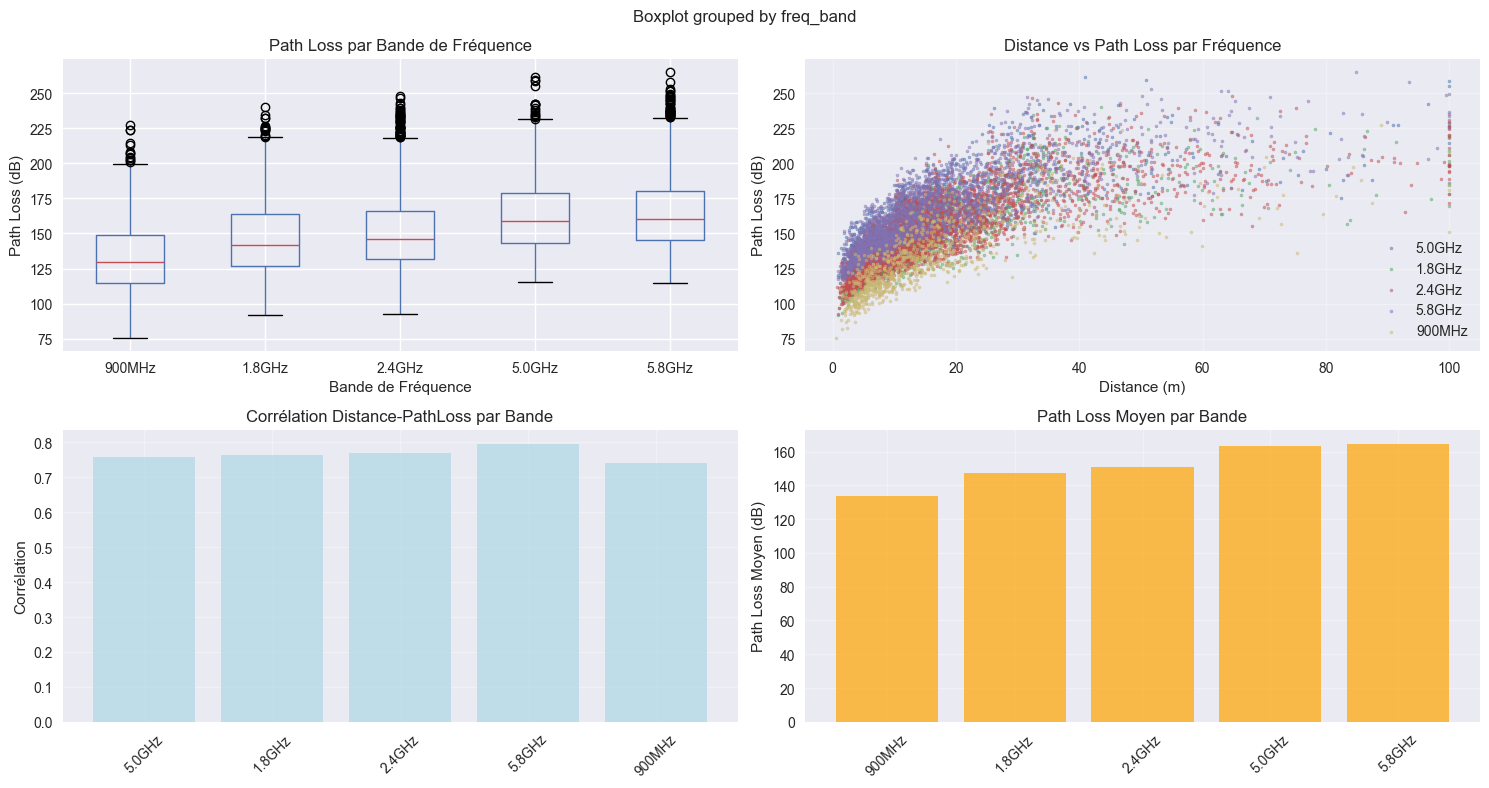

In [9]:
# 5. Visualisation 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 5))

# Subplot 1: Distance vs Murs vs Path Loss
ax1 = fig.add_subplot(131, projection='3d')
scatter = ax1.scatter(df['distance'], df['numwall'], df['pathloss'], 
                     c=df['pathloss'], cmap='viridis', alpha=0.6, s=10)
ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Nombre de Murs')
ax1.set_zlabel('Path Loss (dB)')
ax1.set_title('Relation 3D')
fig.colorbar(scatter, ax=ax1, shrink=0.8)

# Subplot 2: Fréquence vs Path Loss
ax2 = fig.add_subplot(132)
ax2.scatter(df['frequence'], df['pathloss'], alpha=0.6, s=10, color='red')
ax2.set_xlabel('Fréquence (MHz)')
ax2.set_ylabel('Path Loss (dB)')
ax2.set_title('Fréquence vs Path Loss')
ax2.grid(True, alpha=0.3)

# Subplot 3: Distribution des fréquences par type
ax3 = fig.add_subplot(133)
freq_ranges = ['800-1200', '1200-2000', '2000-3000', '3000-5000', '5000+']
freq_counts = [
    len(df[(df['frequence'] >= 800) & (df['frequence'] < 1200)]),
    len(df[(df['frequence'] >= 1200) & (df['frequence'] < 2000)]),
    len(df[(df['frequence'] >= 2000) & (df['frequence'] < 3000)]),
    len(df[(df['frequence'] >= 3000) & (df['frequence'] < 5000)]),
    len(df[df['frequence'] >= 5000])
]
ax3.pie(freq_counts, labels=freq_ranges, autopct='%1.1f%%', startangle=90)
ax3.set_title('Répartition des Fréquences (MHz)')

plt.tight_layout()
plt.show()

# 6. Analyse des tendances par fréquence
plt.figure(figsize=(15, 8))

# Grouper par bandes de fréquence
df['freq_band'] = pd.cut(df['frequence'], 
                        bins=[800, 1200, 2000, 3000, 5000, 6000],
                        labels=['900MHz', '1.8GHz', '2.4GHz', '5.0GHz', '5.8GHz'])

# Boxplot par bande de fréquence
plt.subplot(2, 2, 1)
df.boxplot(column='pathloss', by='freq_band', ax=plt.gca())
plt.title('Path Loss par Bande de Fréquence')
plt.xlabel('Bande de Fréquence')
plt.ylabel('Path Loss (dB)')

# Moyennes par distance et fréquence
plt.subplot(2, 2, 2)
for band in df['freq_band'].dropna().unique():
    band_data = df[df['freq_band'] == band]
    if len(band_data) > 50:  # Seulement si assez de données
        plt.scatter(band_data['distance'], band_data['pathloss'], 
                   alpha=0.5, label=f'{band}', s=5)
plt.xlabel('Distance (m)')
plt.ylabel('Path Loss (dB)')
plt.title('Distance vs Path Loss par Fréquence')
plt.legend()
plt.grid(True, alpha=0.3)

# Corrélations par bande
plt.subplot(2, 2, 3)
correlations = []
bands = []
for band in df['freq_band'].dropna().unique():
    band_data = df[df['freq_band'] == band]
    if len(band_data) > 10:
        corr = band_data['distance'].corr(band_data['pathloss'])
        correlations.append(corr)
        bands.append(band)

plt.bar(bands, correlations, alpha=0.7, color='lightblue')
plt.title('Corrélation Distance-PathLoss par Bande')
plt.ylabel('Corrélation')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Statistiques par bande
plt.subplot(2, 2, 4)
mean_pl_by_band = df.groupby('freq_band')['pathloss'].mean()
plt.bar(mean_pl_by_band.index, mean_pl_by_band.values, alpha=0.7, color='orange')
plt.title('Path Loss Moyen par Bande')
plt.ylabel('Path Loss Moyen (dB)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. 📋 Résumé et Export

Résumé final des résultats et options d'export du dataset.

In [10]:
# Résumé final des résultats
print("="*60)
print("🎯 RÉSUMÉ FINAL DE LA GÉNÉRATION")
print("="*60)

print(f"\n📊 Dataset généré:")
print(f"   - Nombre d'échantillons: {len(df):,}")
print(f"   - Variables: {list(df.columns)}")
print(f"   - Taille en mémoire: {df.memory_usage(deep=True).sum() / 1024:.1f} KB")

print(f"\n📈 Caractéristiques principales:")
print(f"   - Distance: {df['distance'].min():.1f} - {df['distance'].max():.1f} m")
print(f"   - Murs: {df['numwall'].min()} - {df['numwall'].max()}")
print(f"   - Étages: {df['etage'].min()} - {df['etage'].max()}")
print(f"   - Fréquence: {df['frequence'].min():.0f} - {df['frequence'].max():.0f} MHz")
print(f"   - Path Loss: {df['pathloss'].min():.1f} - {df['pathloss'].max():.1f} dB")

print(f"\n🔗 Corrélations clés:")
print(f"   - Distance ↔ Path Loss: {df['distance'].corr(df['pathloss']):.3f}")
print(f"   - Murs ↔ Path Loss: {df['numwall'].corr(df['pathloss']):.3f}")
print(f"   - Étages ↔ Path Loss: {df['etage'].corr(df['pathloss']):.3f}")
print(f"   - Fréquence ↔ Path Loss: {df['frequence'].corr(df['pathloss']):.3f}")

# Validation de la qualité
quality_score = 0
if df['distance'].corr(df['pathloss']) > 0.7:
    quality_score += 3
if df['numwall'].corr(df['pathloss']) > 0.3:
    quality_score += 2
if df['etage'].corr(df['pathloss']) > 0.2:
    quality_score += 1

print(f"\n✅ Score de qualité: {quality_score}/6")
if quality_score >= 5:
    print("   🎉 Excellent dataset - Prêt pour ML")
elif quality_score >= 3:
    print("   👍 Bon dataset - Utilisable")
else:
    print("   ⚠️ Dataset à améliorer")

# Export final
print(f"\n💾 Fichiers générés:")
print(f"   - radio_dataset_notebook.csv ({len(df)} lignes)")

# Option pour export Excel
try:
    df.to_excel('radio_dataset_notebook.xlsx', index=False)
    print(f"   - radio_dataset_notebook.xlsx")
except:
    print(f"   - Excel export: module openpyxl non installé")

print(f"\n🚀 Prêt pour:")
print(f"   - Entraînement de modèles ML")
print(f"   - Analyse de propagation radio")
print(f"   - Recherche et développement")
print(f"   - Validation d'algorithmes")

print("\n" + "="*60)
print("✨ GÉNÉRATION TERMINÉE AVEC SUCCÈS!")
print("="*60)

🎯 RÉSUMÉ FINAL DE LA GÉNÉRATION

📊 Dataset généré:
   - Nombre d'échantillons: 10,000
   - Variables: ['distance', 'numwall', 'etage', 'frequence', 'pathloss', 'freq_band']
   - Taille en mémoire: 401.0 KB

📈 Caractéristiques principales:
   - Distance: 0.5 - 100.0 m
   - Murs: 0 - 10
   - Étages: 0 - 4
   - Fréquence: 800 - 5957 MHz
   - Path Loss: 75.7 - 265.1 dB

🔗 Corrélations clés:
   - Distance ↔ Path Loss: 0.721
   - Murs ↔ Path Loss: 0.682
   - Étages ↔ Path Loss: 0.749
   - Fréquence ↔ Path Loss: 0.333

✅ Score de qualité: 6/6
   🎉 Excellent dataset - Prêt pour ML

💾 Fichiers générés:
   - radio_dataset_notebook.csv (10000 lignes)
   - Excel export: module openpyxl non installé

🚀 Prêt pour:
   - Entraînement de modèles ML
   - Analyse de propagation radio
   - Recherche et développement
   - Validation d'algorithmes

✨ GÉNÉRATION TERMINÉE AVEC SUCCÈS!
